# Clouds In Transmission

Need to retire contribution_clouds_transmission (even though its faster)

Notebook that shows all clouds functionalities and their effects (new and old) on tranmission spectra

[Deck + Haze](#1)
<br><br>

[Mie Scatering Models](#Mie-Scattering-Cloud-Models)
- [Aerosol Database](##1-aerosols-in-the-database)
- [User Inputted Aerosol](##2-user-inputted-aerosol)
- [Constant Refractive Index](##3-constant-refractive-index)
<br><br>

[Mie Cloud Models](#Mie-Cloud-Models)
- [Fuzzy Deck](#fuzzy-deck-model)
- [Slab](#slab)
- [Uniform X](#uniform-x)

<br><br>
[Adding and Using Your Own Aerosols](#adding-your-own-aerosols)

# Importance of Clouds

<img src="./Transmission-cloud-effect-fixed.png" />

Clouds are important to consider in transmission data due to three reasons

1. In tidally locked exoplanets, there exists a large temperature gradient between the day and night side. We are probing the day-night terminator with transmission spectra, where hot gas is being cooled as it circulates to the night side. We can expect in certain planets that this large temperature gradient will drive aerosol formation. 

2. Due to the grazing geometry of transmision spectra, even if aerosols have low optical depth/low mixing ratio, they can impart large features. (Its almost like a sunset geometry, where the starlight has to pass through a large amount of the atmosphere before reaching the observer).

3. In transmission, aerosol scattering and absorption is taken to be lost of the beam (no directional scattering considered)

# Wasp 17b Planetary Properties and Opac

First, we define a planet that we will be using for the rest of the notebook (Wasp-17b). We only include water in our models in order to clearly see how clouds affect the transmission spectra.

In [ ]:
from POSEIDON.core import wl_grid_constant_R
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J
import scipy.constants as sc 
from POSEIDON.clouds import vary_one_parameter, plot_clouds

import numpy as np
import matplotlib.pyplot as plt

#***** Define stellar properties *****#

R_s = 1.49*R_Sun     # Stellar radius (m)
T_s = 6550            # Stellar effective temperature (K)
Met_s = -0.25          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.2        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'Clouds'  # Planet name used for plots, output files etc.

R_p = 1.87*R_J                           # Planetary radius (m)
R_p = 1.722*R_J
M_p = 0.78*M_J
g_p = (sc.G*M_p)/(R_p**2)         # Gravitational field of planet (m/s^2)
T_eq = 1447

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

CB_color_cycle = ['#0072B2', '#009E73', '#D55E00', '#CC79A7',
                 '#F0E442', '#56B4E9','#56B4E9']

# Intialize wavelength grid
wl_min = 0.2    # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 10000       # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p # Radius at reference pressure

In [2]:
from POSEIDON.core import read_opacities
from POSEIDON.core import define_model

model_name = 'Load-Opac'

bulk_species = ['H2','He']
param_species = ['H2O']

model_load_opac = define_model(model_name,bulk_species,param_species,
                               PT_profile = 'isotherm', X_profile = 'isochem')

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_load_opac, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Opacity pre-interpolation complete.


# Deck Haze Model
<a id='1'></a>
This model implements an opaque cloud extending up to $P_{cloud}$ below which no electromagnetic radiation can pass through, and a haze that is uniformly distributed throughout the atmosphere. This model fits for both a flattening of a spectrum due to an opaque cloud deck and an enhanced short wavelngth slope/transit depth that can obscure Na, K, TiO, VO, etc absorption features. 
<br><br>
Note that this model in a retrieval will fit for the short wavelength slope by design. However, the 'haze' in this model is a mathematical perscription and does not represent a 'real' molecule. See Mie Scattering sections for how to implement a 'real' aerosol or haze species. 
<br><br>
$\lambda_0$ is the reference wavelength (350 nm), $\sigma_0$ is the H2-Rayleigh scattering cross section at the reference wavelength (5.31e-31 $m^2$), a is the Rayleigh-enhancement factor and $\gamma$ is the scattering slope. 
<br><br>

$$
\begin{equation}
\kappa_{cloud}=
    \begin{cases}
        a \sigma_0 (\lambda / \lambda_0)^{\gamma} & P < P_{cloud}\\
        \infty & P \geq P_{cloud}
    \end{cases}
\end{equation}
$$

<br><br>

We will explore how each 'tunable' parameter affects a spectrum. 

In [3]:
from POSEIDON.core import define_model

model_name = 'Deck-Haze'

bulk_species = ['H2','He']
param_species = ['H2O']

model_deck_haze = define_model(model_name,bulk_species,param_species,
                               PT_profile = 'isotherm', X_profile = 'isochem',
                               cloud_model = 'MacMad17', cloud_type = 'deck_haze')

print("PT parameters : " + str(model_deck_haze['PT_param_names']))
print("X parameters : " + str(model_deck_haze['X_param_names']))
print("Cloud parameters : " + str(model_deck_haze['cloud_param_names']))

PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_a' 'gamma' 'log_P_cloud']


In [4]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_a       = 1.7
gamma       = -8 
log_P_cloud = -2

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_a, gamma, log_P_cloud])

# Make atmosphere 
atmosphere_deck_haze = make_atmosphere(planet, model_deck_haze, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

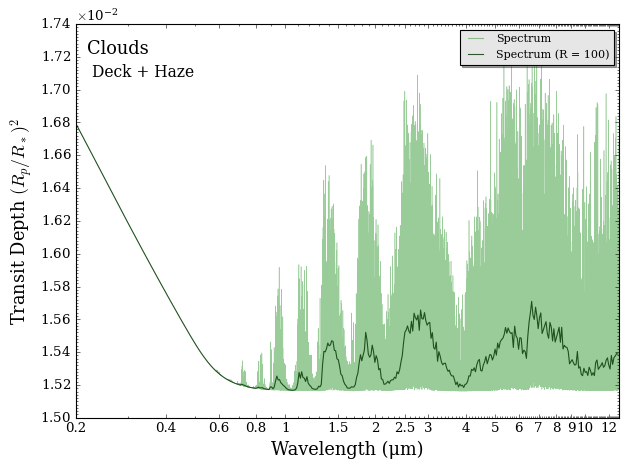

In [5]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_deck_haze = compute_spectrum(planet, star, model_deck_haze, atmosphere_deck_haze, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_deck_haze, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Deck + Haze',
                   save_fig = False) 

Lets check out how the deck + haze is actually affecting the spectrum, using this helper function

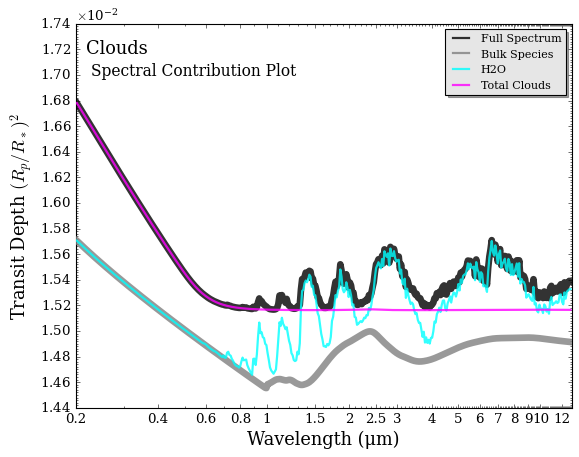

<Figure size 853.36x480 with 0 Axes>

In [6]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_deck_haze, atmosphere_deck_haze, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan','magenta'])

Here we can see both the effects of the deck and the haze. The opaque cloud tends to flatten the spectrum after the UVIS slope. The slope dominates in the shorter wavelengths. We will now vary each parameter just to see how they work.

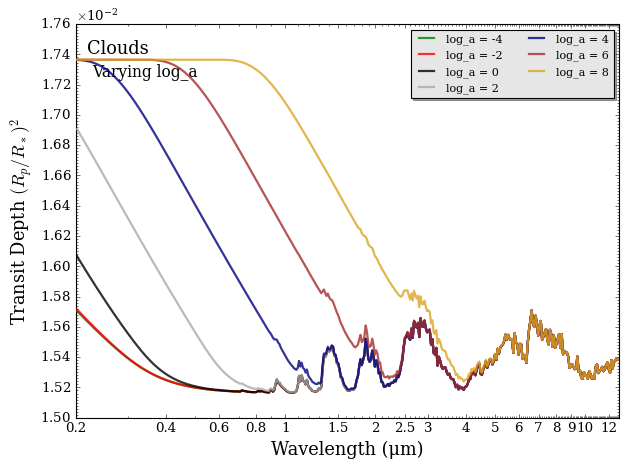

In [8]:
param_name = 'log_a'
vary_list = [-4,-2,0,2,4,6,8]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

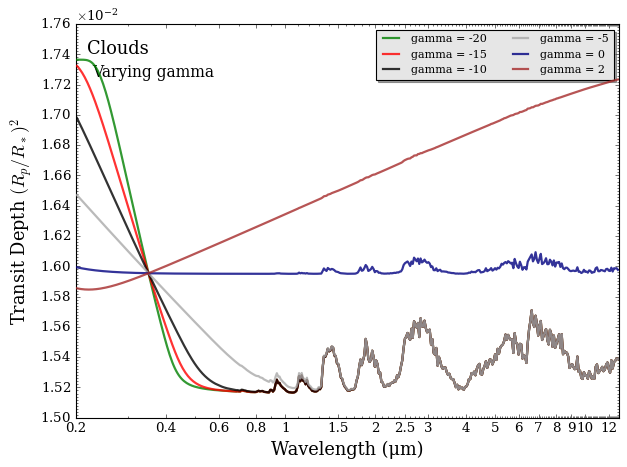

In [9]:
param_name = 'gamma'
vary_list = [-20,-15,-10,-5,0,2]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

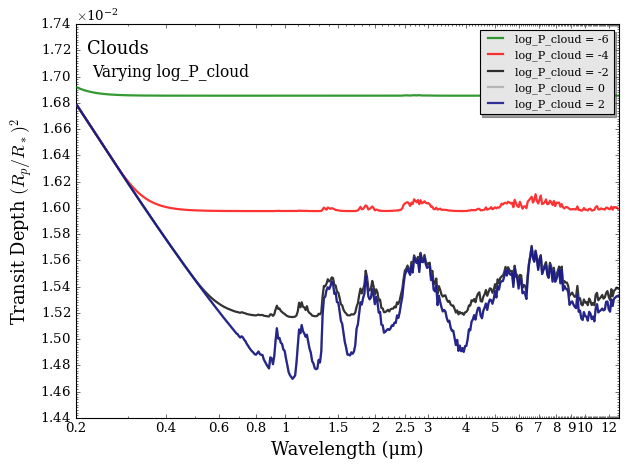

In [10]:
param_name = 'log_P_cloud'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

# Mie Scattering Cloud Models

Before running this section, please make sure the aerosol_database_emission.hdf5 is in the inputs/opacity folder. 

For more information on the database, and how to generate and add species to it, please refer to the 'Make-Aerosol-Database' tutorial notebook.

## Mie Aerosol Types

POSEIDON currently supports three different types of aerosol inputs. 

1) Aerosols in the database
2) User inputted aerosol lab data
2) Aersols with constant refractive indices

For more details on the aerosols in the database, see 'Make-Aerosol-Database' tutorial notebook.

Users can also input their own aerosol lab data to POSEIDON. POSEIDON will use the Mie scattering algorithm to calcualte the cross sections and other properties for any user inputted lab data 'on the fly'. This functionality is good for quick forward models. For retrievals, users can add their aerosol to the aerosol database.

Finally, users can initialize a model with aerosols that have a constant refractive index over the entire wavelength range.

This section will only be covering aerosol specific properties. How to initialize models with the three different types of aerosol inputs + aerosol cloud models will be described in the next section. 

## 1. Aerosols in the Database 

Lets check the available species in the database.

In [11]:
from POSEIDON.supported_chemicals import aerosol_supported_species

print(aerosol_supported_species)

['ADP' 'Al2O3' 'Al2O3_KH' 'C' 'CH4' 'CaTiO3' 'CaTiO3_KH' 'Cr'
 'ExoHaze_1000xSolar_300K' 'ExoHaze_1000xSolar_400K' 'Fe' 'Fe2O3'
 'Fe2SiO4_KH' 'FeO' 'FeS' 'FeSiO3' 'H2O' 'H2SO4' 'Hexene' 'Hibonite'
 'IceTholin' 'KCl' 'Mg2SiO4_amorph_sol_gel' 'Mg2SiO4_amorph'
 'Mg2SiO4_Fe_poor' 'Mg2SiO4_Fe_rich' 'Mg2SiO4_crystalline'
 'Mg4Fe6SiO3_amorph_glass' 'Mg5Fe5SiO3_amorph_glass'
 'Mg8Fe12SiO4_amorph_glass' 'Mg8Fe2SiO3_amorph_glass' 'MgAl2O4'
 'MgFeSiO4_amorph_glass' 'MgO' 'MgSiO3_amorph' 'MgSiO3_crystalline'
 'MgSiO3' 'MgSiO3_amorph_glass' 'MgSiO3_sol_gel' 'MnS' 'MnS_KH' 'MnS_Mor'
 'Na2S' 'NaCl' 'NanoDiamonds' 'NH3' 'NH4SH' 'S8' 'Saturn-Phosphorus-Haze'
 'SiC' 'SiO' 'SiO2' 'SiO2_amorph' 'SiO2_crystalline_2023' 'Soot'
 'Soot_6mm' 'Tholin' 'Tholin-CO-0625' 'Tholin-CO-1' 'TiC' 'TiO2_anatase'
 'TiO2_rutile' 'VO' 'ZnS']


Lets query the database directly.

NOTE : Loading in the database directly as shown below is not necessary for running forward models and retrievals. This is just to display how to do so if you wish to explore the parameter space of an aerosol species

In [12]:
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid
import matplotlib.pyplot as plt 

species = 'SiO2'

# Load in the grid 
aerosol_grid = load_aerosol_grid([species])

# Test to see if the cross sections come out with SiO2 particle, 0.01 um sized
r_m = 0.01

# This formula loads in the grid 
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Lets load in the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_abs = sigma_Mie_interp_array[species]['eff_abs']
eff_scat = sigma_Mie_interp_array[species]['eff_scat']
eff_back = sigma_Mie_interp_array[species]['eff_back']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

Reading in database for aerosol cross sections...


Lets plot the effective extinction cross section. 

The effective extinction cross section is the total loss of photons due to scattering and absorption processes. This is used in transmission geometries.

The single scattering albedo and asymmetry parameter are expored further in the 'Scattering' and 'Reflection' tutorial notebooks.

Here we see that SiO2 has an absorption feature around 8um and a scattering slope in the shorter wavelengths. The benefit to using real aerosols is that you get both a scattering slope and a longer wavelength absorption feature! 

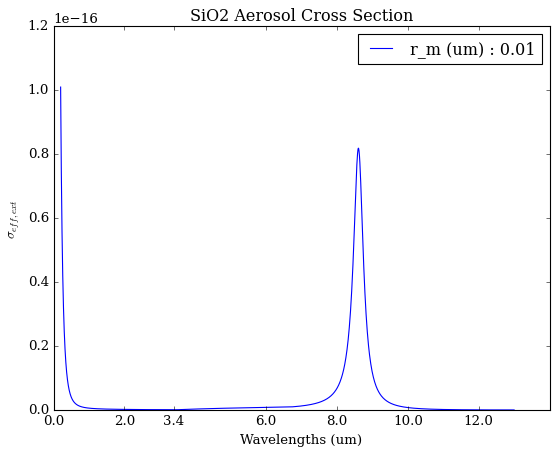

In [13]:
label = 'r_m (um) : ' + str(r_m)
title = species + ' Aerosol Cross Section'

plt.plot(wl,eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('$\sigma_{eff,ext}$')
plt.xticks((0,2,3.4,6,8,10,12))
plt.show()

## 2. User-Inputted Aerosol

Here we will load in the H2O_complex txt file, which contains the refractive indices for H2O aerosols. Its reccomended to load in the refractive indices and load them into a couple of forward models to make sure they behave the way you expect. Then you can add them manually to the database for retrievals 

Lets load in an analyze the properties of the H2O txt file

NOTE : Calculating the aerosols properties will take 5-10 seconds since the properties are being directly computed

[Adding and Using Your Own Aerosols](#adding-your-own-aerosols) explores how to actually use user inputted aerosols in the forward model

Loading in :  ./H2O_complex.txt


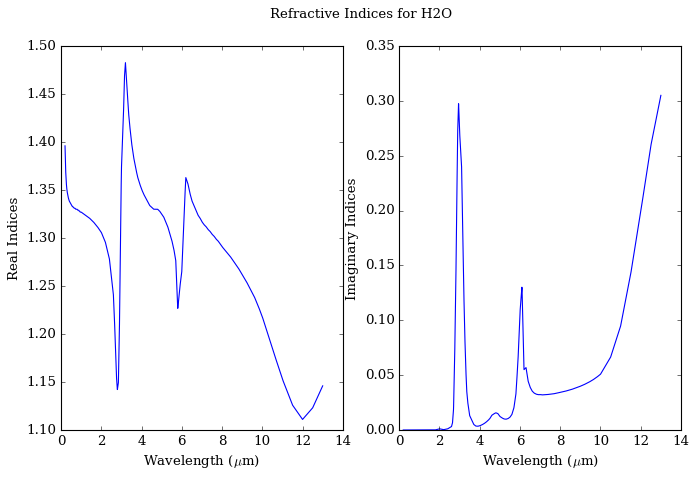

Loading in :  ./H2O_complex.txt


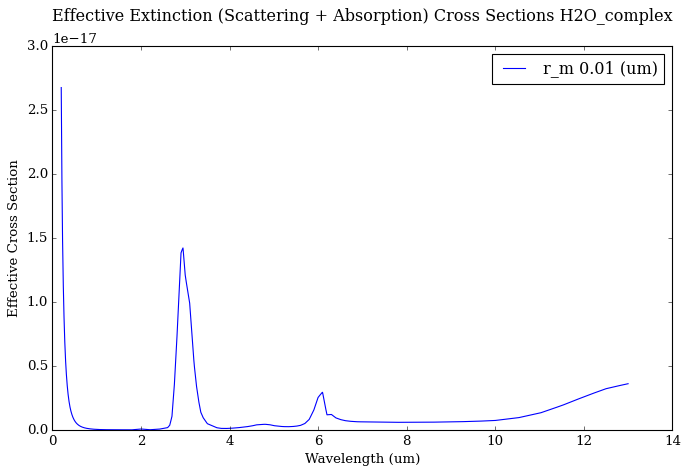

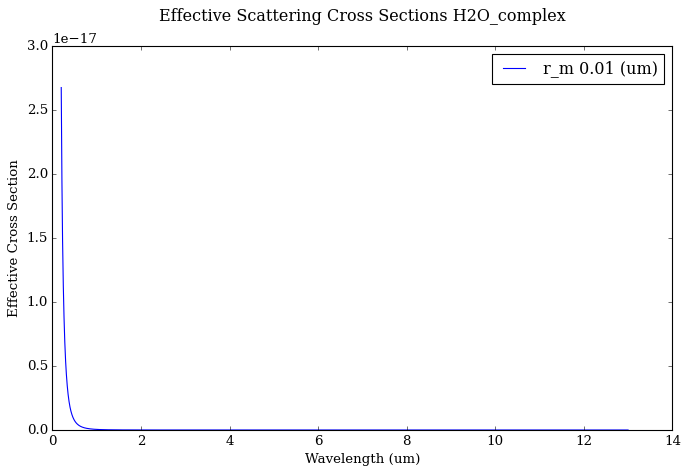

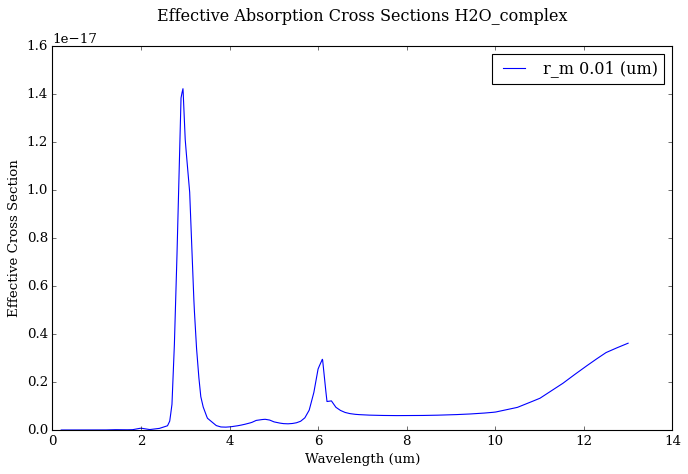

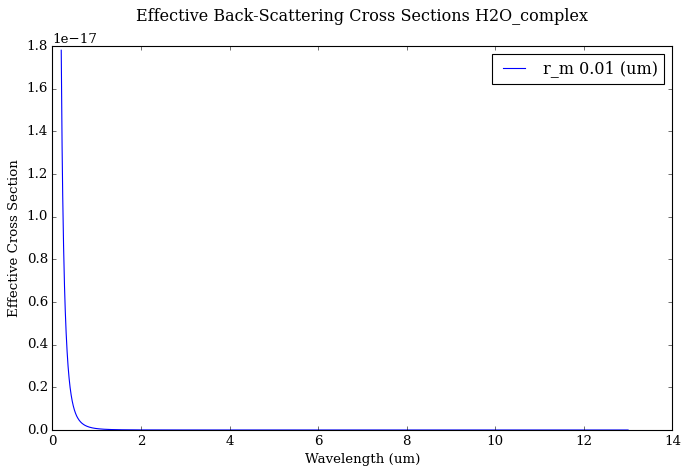

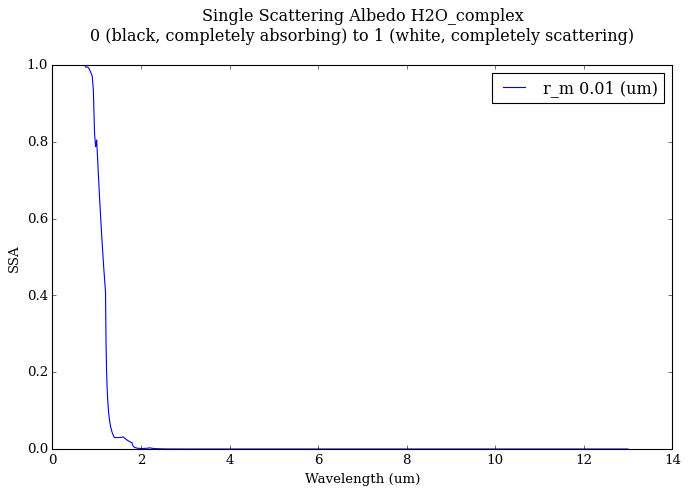

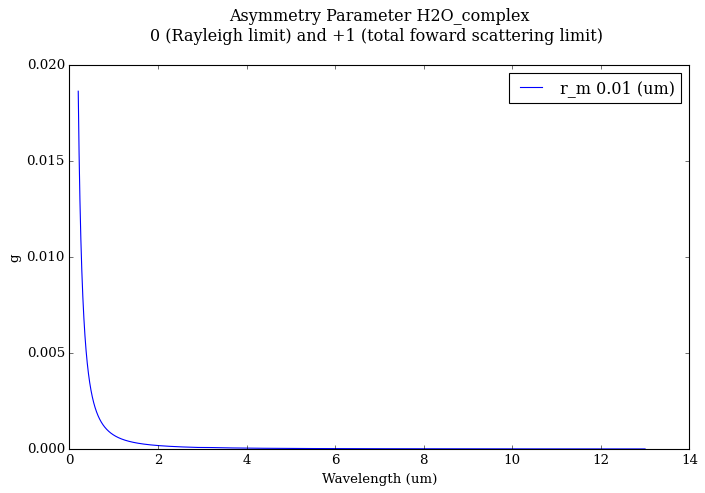

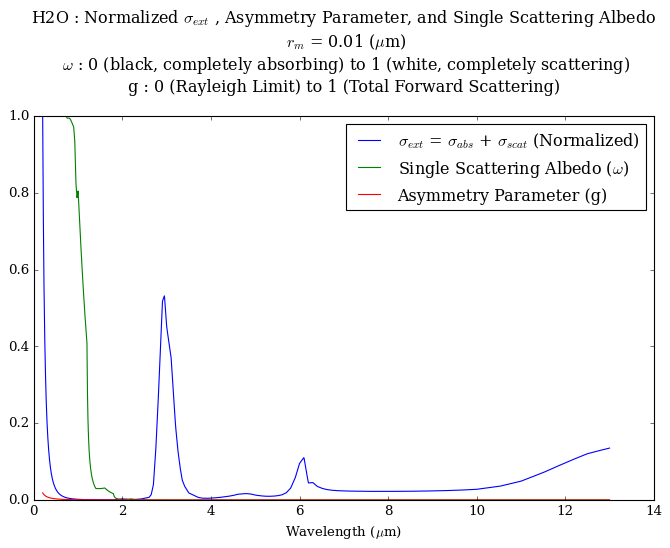

In [14]:
from POSEIDON.clouds import plot_refractive_indices_from_file, plot_effective_cross_section_from_file
import numpy as np 
from scipy.interpolate import interp1d

# First, lets check how the cross sections that our own file : 'H2O_complex.txt' makes
file_name = './H2O_complex.txt'

# Plotting the refractive indices 
plot_refractive_indices_from_file(wl, file_name)

# Plotting the cross section from LX_MIE 
r_m = 0.01 # mean particle size

plot_effective_cross_section_from_file(wl, r_m, file_name)

## 3. Constant Refractive Index 

Here, you just define the real and imaginary components of the refrative index, which will be assumed to be constant over wavelength space. 

As you can see below, this perscription will result in something similar to the haze shown before. 

In the future, the refractive index will be allowed to be a free parameter at specific wavelengths to freely retrieve aerosols (a technique used in solar system retrievals). Single scattering albedo retrievals will also be added in a similar way.

[Adding and Using Your Own Aerosols](#adding-your-own-aerosols) explains how to use constant refractive indices in the forward model.

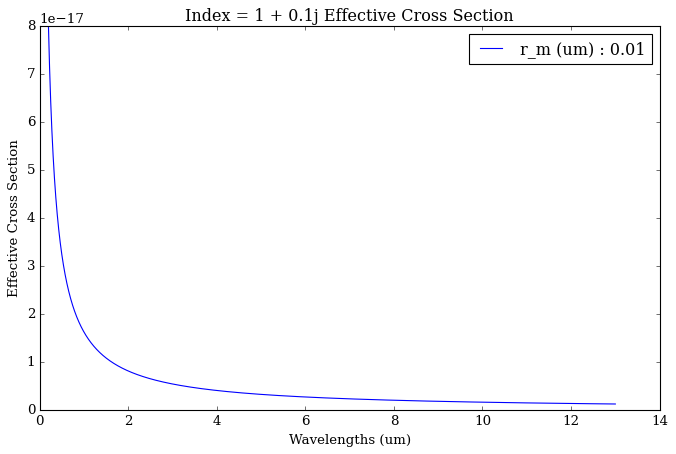

In [15]:
from POSEIDON.clouds import plot_effective_cross_section_free

r_m = 0.01  #um
r_i_real = 1
r_i_complex = 0.1

plot_effective_cross_section_free(wl, r_m, r_i_real, r_i_complex)

# Mie Cloud Models 

There are a few cloud models that are new and specific to Mie scattering. 

1. Fuzzy Deck Model 
2. Slab Model
3. Uniform X Model

Below, we will explore each model and how they imprint on spectra.

<img src="./Cloud-Models.png"/>

When defining a Mie scattering cloud model : 

1. Define your aerosol_species 
- Species name from the database (e.g. 'SiO2')
- 'file_read' if you are using your own aerosol data
- 'free' if its a constant refractive index

2. cloud_model = 'Mie'

3. cloud_type = 'fuzzy_deck', 'slab', 'uniform_X', 'opaque_deck_plus_slab', 'fuzzy_deck_plus_slab'

Each model allows for multiple aerosols (only for database species). For the deck_plus_slab model, it is assumed that the first aerosol species is the 'deck' species and the rest are slabs. 

# Fuzzy Deck Model

The fuzzy deck model is adapted from Zhang et al 2018 (https://arxiv.org/abs/1811.11761). In essence, this model is similar to the deck + haze described before in that there is an opaque cloud deck located at P_cloud plus an aerosol species above the deck. The free parametrs for a fuzzy deck model are : 

$log(P_{top,deck})$ : The pressure at which the opaque cloud ends 

$log(r_m)$     : The mean particle size in um (log = -3 -> 0.001 um)

$log(n_{max})$   : Maximum number density (defines the number density at log_P_cloud)

$f$           : fractional scale height (determines how 'fast' the number density falls off, 'fuzziness', ~0 = no fuzziness, ~1 = pretty much contant mixing ratio)

Note that if you are loading in your own refractive indices, or using a constant refractive index, you will also need to define : 

$r_{i,real}$ and $r_{i,complex}$ are the real and complex components of the refractive index for the free case. 

<br><br>

The number density of aerosols above the cloud deck is given by
$$
\begin{equation}
n = n_0 \; exp(\frac{-h}{f H_{gas}})
\end{equation} 
$$

where $h$ is the height above the cloud deck, $H_{gas}$ is the scale height

In [4]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Fuzzy_Deck_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_fuzzy_deck = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'fuzzy_deck',
                     aerosol_species = aerosol_species)


# Check the free parameters defining this model
print("PT parameters : " + str(model_fuzzy_deck['PT_param_names']))
print("X parameters : " + str(model_fuzzy_deck['X_param_names']))
print("Cloud parameters : " + str(model_fuzzy_deck['cloud_param_names']))


Reading in database for aerosol cross sections...
PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_deck_SiO2' 'log_r_m_SiO2' 'log_n_max_SiO2' 'f_SiO2']


In [5]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_deck_SiO2 = 0
log_r_m_SiO2        = -2
log_n_max_SiO2      = 20
f_SiO2              = 0.3

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_P_top_deck_SiO2, log_r_m_SiO2, log_n_max_SiO2, f_SiO2])

# Make atmosphere 
atmosphere_fuzzy_deck = make_atmosphere(planet, model_fuzzy_deck, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Lets see this paramterization in action

1. In terms of number density 
2. In terms of mixing ratio 

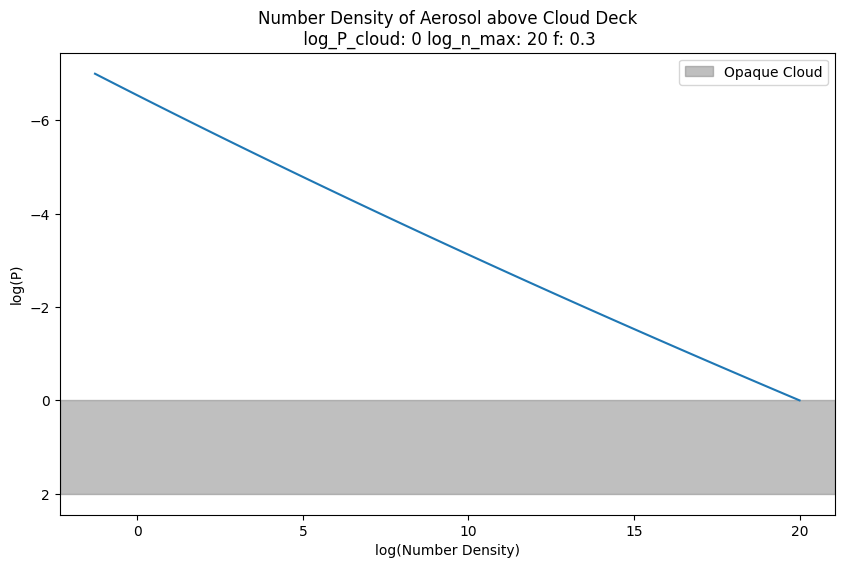

Max mixing ratio :  -4.7807354712741414
Min mixing ratio :  -19.061111830254763


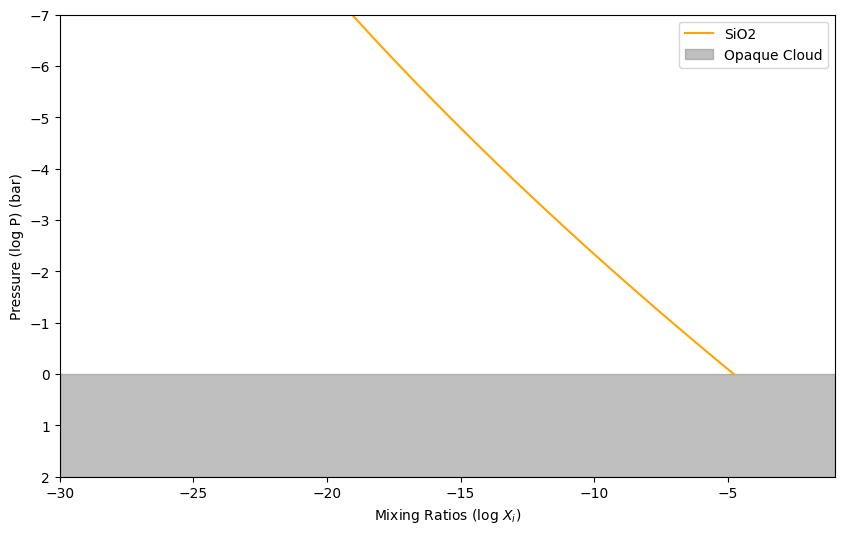

In [6]:
from POSEIDON.clouds import plot_aerosol_number_density_fuzzy_deck, plot_clouds

plot_aerosol_number_density_fuzzy_deck(atmosphere_fuzzy_deck,log_P_top_deck_SiO2,log_n_max_SiO2,f_SiO2)
plot_clouds(planet,model_fuzzy_deck,atmosphere_fuzzy_deck)

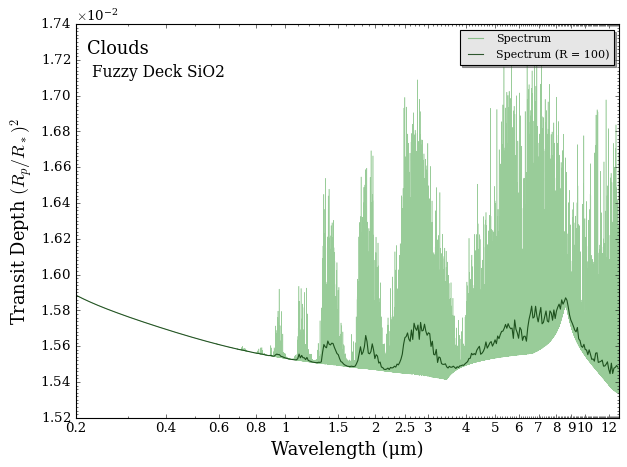

In [19]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_fuzzy_deck = compute_spectrum(planet, star, model_fuzzy_deck, atmosphere_fuzzy_deck, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_fuzzy_deck, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Fuzzy Deck SiO2',
                   save_fig = False) 

Lets analyze whats going on 

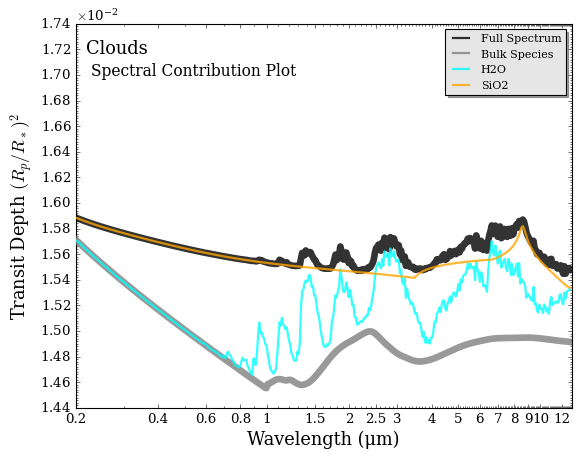

<Figure size 853.36x480 with 0 Axes>

In [20]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_fuzzy_deck, atmosphere_fuzzy_deck, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

Reading in database for aerosol cross sections...


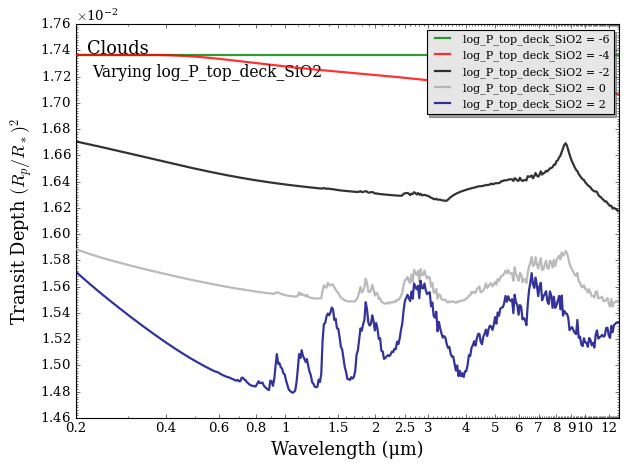

In [21]:
param_name = 'log_P_top_deck_SiO2'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


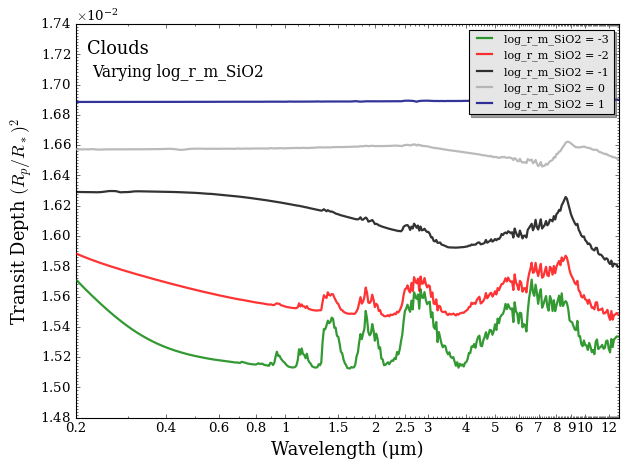

In [22]:
param_name = 'log_r_m_SiO2'
vary_list = [-3,-2,-1,0,1]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


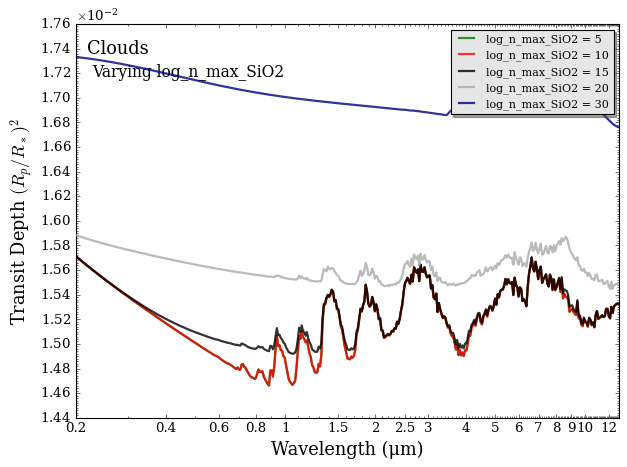

In [23]:
param_name = 'log_n_max_SiO2'
vary_list = [5,10,15,20,30]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


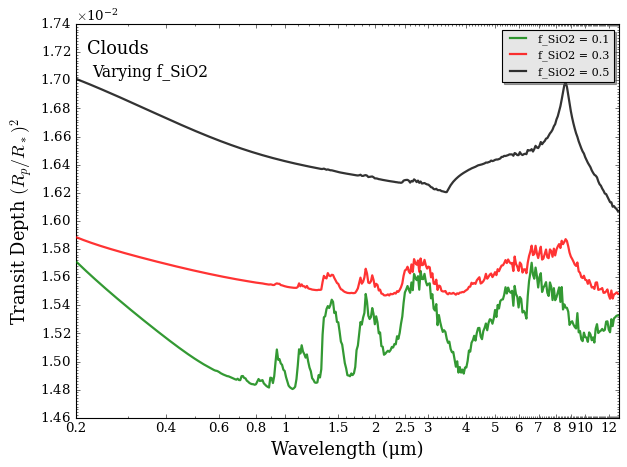

In [24]:
param_name = 'f_SiO2'
vary_list = [0.1,0.3, 0.5]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

# Slab

The slab model places a cloud spanning pressure space (from log_P_cloud_top to log_P_cloud_top + Delta_P) where an aerosol has a constant mixing ratio in that pressure range. The model is defined by : 

$log(P_{top, slab})$ : The pressure at which the top of the slab is located

$\Delta log(P)$ : The range the slab extends

$log(r_m)$     : The mean particle size in um (log = -3 -> 0.001 um)

$log(X)$        : Mixing ratio of aerosol species within the slab

Note that if you are loading in your own refractive indices, or using a constant refractive index, you will also need to define : 

$r_{i,real}$ and $r_{i,complex}$ are the real and complex components of the refractive index for the free case. 


In [25]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Slab_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_slab = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'slab',
                     aerosol_species = aerosol_species)


# Check the free parameters defining this model
print("PT parameters : " + str(model_slab['PT_param_names']))
print("X parameters : " + str(model_slab['X_param_names']))
print("Cloud parameters : " + str(model_slab['cloud_param_names']))


Reading in database for aerosol cross sections...
PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2']


In [26]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_slab_SiO2 = -5
Delta_log_P_SiO2    = 2
log_r_m_SiO2        = -2
log_X_SiO2          = -12

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = ([log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2])

# Make atmosphere 
atmosphere_slab = make_atmosphere(planet, model_slab, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

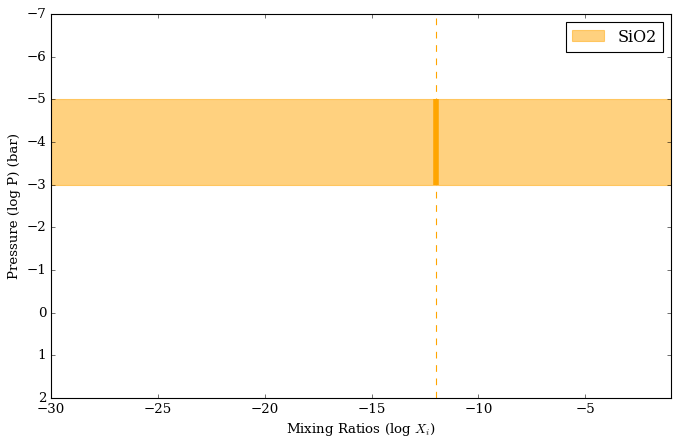

In [27]:
from POSEIDON.clouds import plot_clouds

plot_clouds(planet,model_slab,atmosphere_slab)

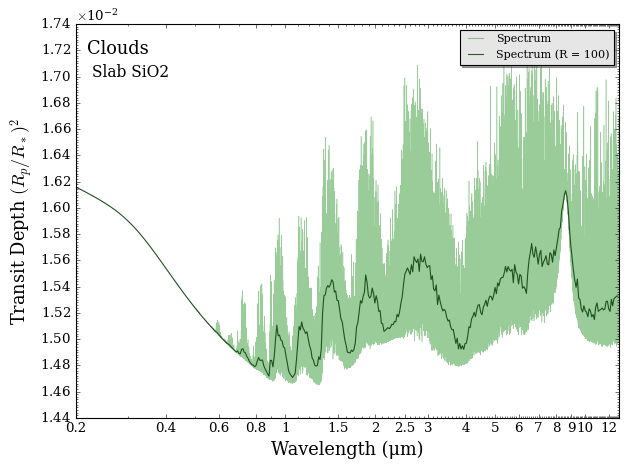

In [28]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_slab = compute_spectrum(planet, star, model_slab, atmosphere_slab, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_slab, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Slab SiO2',
                   save_fig = False) 

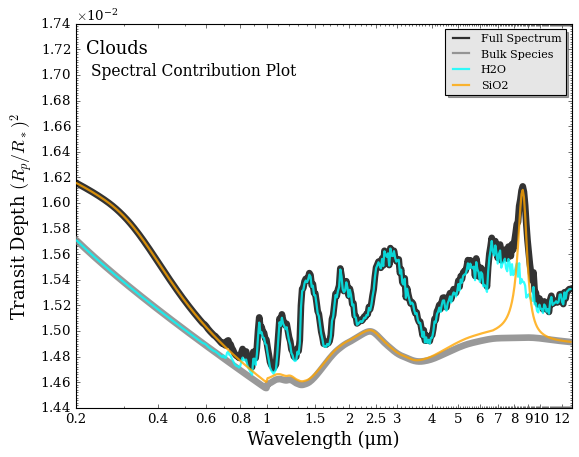

<Figure size 853.36x480 with 0 Axes>

In [29]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star,  model_slab, atmosphere_slab, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

Reading in database for aerosol cross sections...


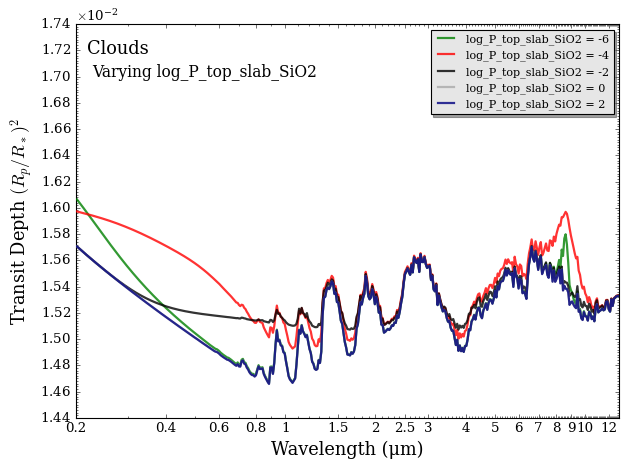

In [30]:
param_name = 'log_P_top_slab_SiO2'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


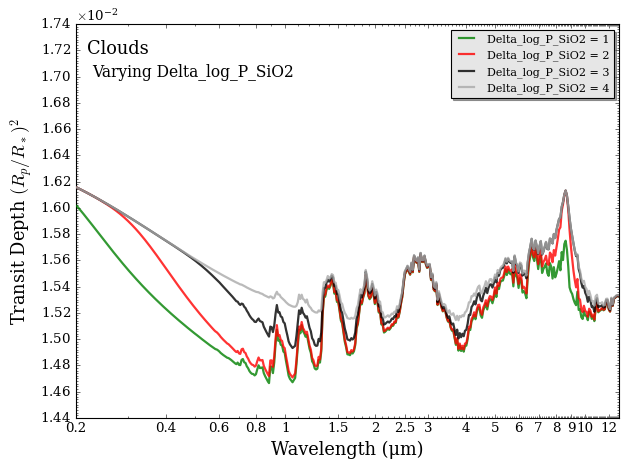

In [31]:
param_name = 'Delta_log_P_SiO2'
vary_list = [1,2,3,4]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


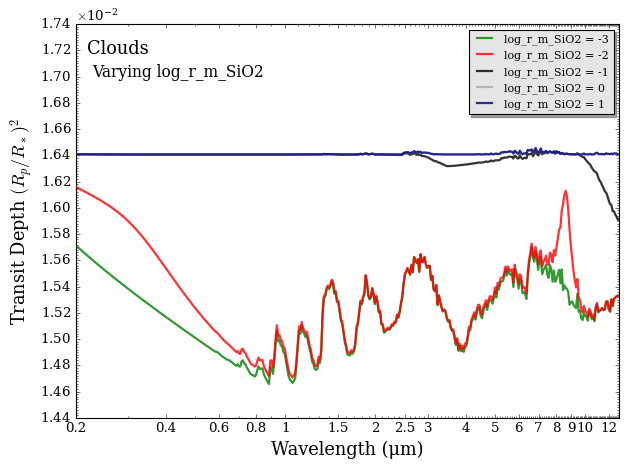

In [32]:
param_name = 'log_r_m_SiO2'
vary_list = [-3,-2,-1,0,1]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


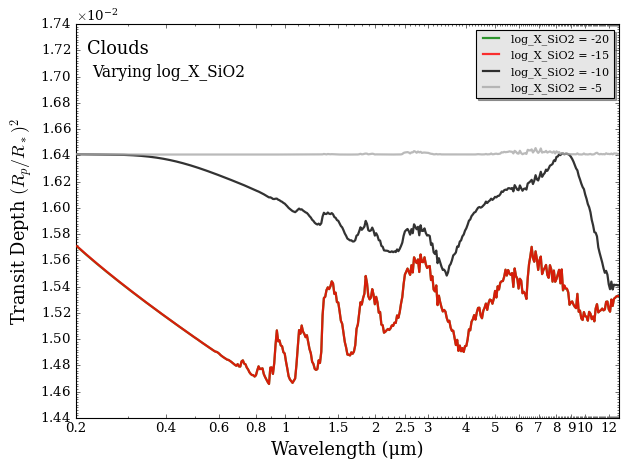

In [33]:
param_name = 'log_X_SiO2'
vary_list = [-20,-15,-10,-5]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

You can define multiple slabs! And also combine models

In [34]:
model_name = 'Multiple_Slabs'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']

aerosol_species = ['SiO2', 'MgSiO3']

model_multiple_slabs = define_model(model_name, bulk_species, param_species,
                                    PT_profile = 'isotherm', X_profile = 'isochem',
                                    cloud_model = 'Mie',cloud_type = 'slab',
                                    aerosol_species = aerosol_species)

model_name = 'Opaque_deck_plus_slab'

model_opaque_plus_slabs = define_model(model_name, bulk_species, param_species,
                                        PT_profile = 'isotherm', X_profile = 'isochem',
                                        cloud_model = 'Mie',cloud_type = 'opaque_deck_plus_slab',
                                        aerosol_species = aerosol_species)

model_name = 'Fuzzy_deck_plus_slab'
aerosol_species = ['Fe','SiO2', 'MgSiO3']

model_fuzzy_deck_plus_slabs = define_model(model_name, bulk_species, param_species,
                                            PT_profile = 'isotherm', X_profile = 'isochem',
                                            cloud_model = 'Mie',cloud_type = 'fuzzy_deck_plus_slab',
                                            aerosol_species = aerosol_species)

print()
print("Cloud parameters (slabs) : " + str(model_multiple_slabs['cloud_param_names']))
print()
print("Cloud parameters (opaque deck + slabs) : " + str(model_opaque_plus_slabs['cloud_param_names']))
print()
print("Cloud parameters (fuzzy deck + slabs) : " + str(model_fuzzy_deck_plus_slabs['cloud_param_names']))

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...
This mode assumes that the first aerosol in the list is the deck species, rest are slab species
Reading in database for aerosol cross sections...

Cloud parameters (slabs) : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']

Cloud parameters (opaque deck + slabs) : ['log_P_top_deck' 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2'
 'log_X_SiO2' 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3'
 'log_r_m_MgSiO3' 'log_X_MgSiO3']

Cloud parameters (fuzzy deck + slabs) : ['log_P_top_deck_Fe' 'log_r_m_Fe' 'log_n_max_Fe' 'f_Fe'
 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']


In [35]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Slabs 
log_P_top_slab_SiO2 = -5
Delta_log_P_SiO2    = 1
log_r_m_SiO2        = -2
log_X_SiO2          = -12

log_P_top_slab_MgSiO3 = - 3
Delta_log_P_MgSiO3    = 1
log_r_m_MgSiO3        = -2
log_X_MgSiO3          = -13

cloud_params = ([log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2, 
                 log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])
                 
atmosphere_multiple_slabs = make_atmosphere(planet, model_multiple_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


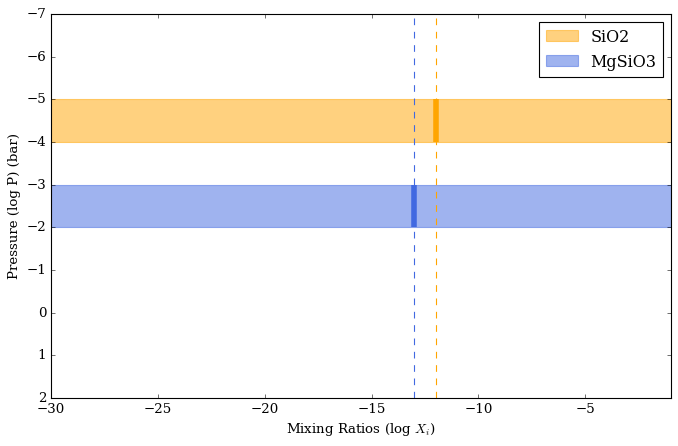

In [36]:
plot_clouds(planet,model_multiple_slabs,atmosphere_multiple_slabs)

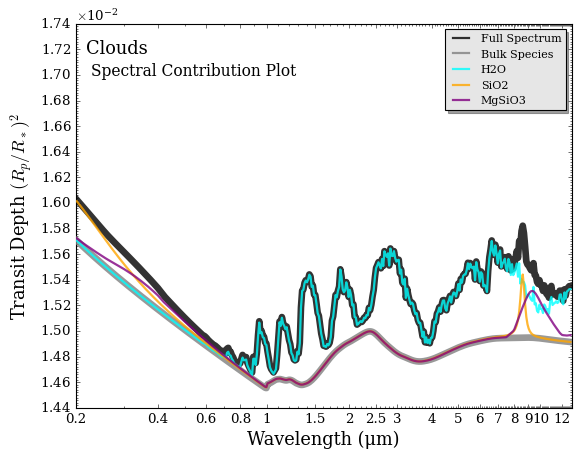

<Figure size 853.36x480 with 0 Axes>

In [37]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_multiple_slabs,atmosphere_multiple_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple'])

In [38]:
# Opaque + Slabs
log_P_top_deck        = -2

cloud_params = ([log_P_top_deck,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_opaque_plus_slabs = make_atmosphere(planet, model_opaque_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Note that the contribution function does not show the deck seperately. However, as shown before, it just flattens the spectrum

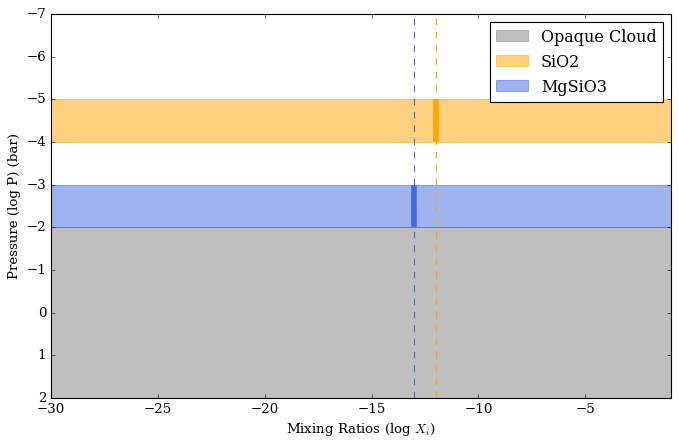

In [39]:
plot_clouds(planet,model_opaque_plus_slabs,atmosphere_opaque_plus_slabs)

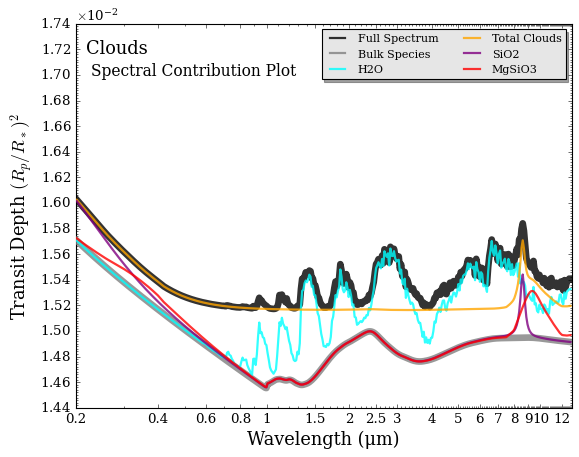

<Figure size 853.36x480 with 0 Axes>

In [40]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_opaque_plus_slabs,atmosphere_opaque_plus_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple', 'red'])

In [41]:
# Fuzzy Deck + Slabs
log_P_top_deck_Fe     = 0
log_r_m_Fe            = -2
log_n_max_Fe          = 20
f_Fe                  = 0.2


cloud_params = ([log_P_top_deck_Fe,log_r_m_Fe,log_n_max_Fe,f_Fe,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3,log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_fuzzy_deck_plus_slabs = make_atmosphere(planet, model_fuzzy_deck_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

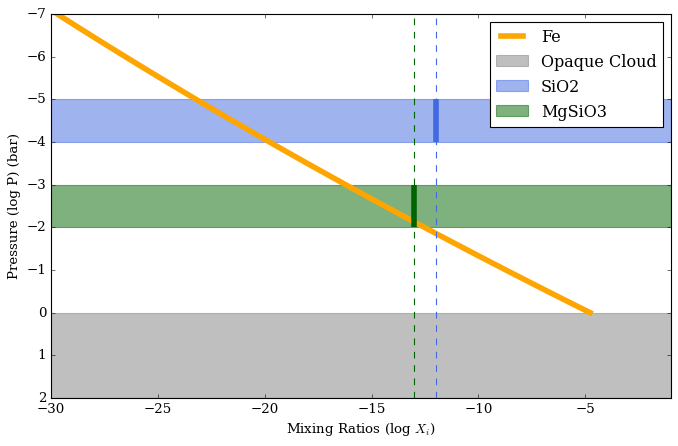

In [42]:
plot_clouds(planet,model_fuzzy_deck_plus_slabs,atmosphere_fuzzy_deck_plus_slabs)

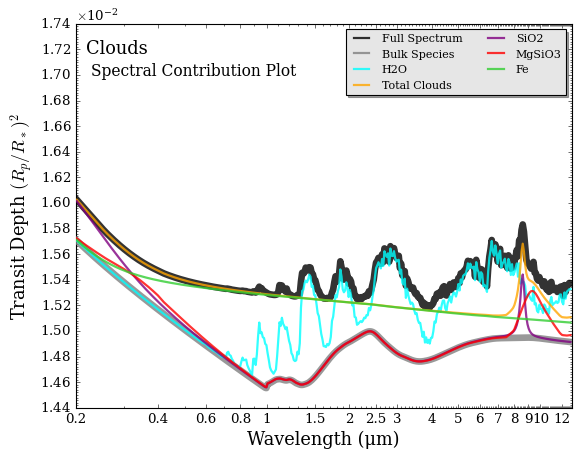

<Figure size 853.36x480 with 0 Axes>

In [43]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_fuzzy_deck_plus_slabs,atmosphere_fuzzy_deck_plus_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3', 'Fe'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple', 'red', 'limegreen'])

## Uniform X 

The uniform X model places a cloud spanning the entire pressure space where an aerosol has a constant mixing ratio. The model is defined by : 

$log(r_m)$     : The mean particle size in um (log = -3 -> 0.001 um)

$log(X)$        : Mixing ratio of aerosol species within the slab

Note that if you are loading in your own refractive indices, or using a constant refractive index, you will also need to define : 

$r_{i,real}$ and $r_{i,complex}$ are the real and complex components of the refractive index for the free case. 

In [44]:
model_name = 'Uniform_X'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_uniform_x = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

print()
print("Cloud parameters (Uniform X) : " + str(model_uniform_x['cloud_param_names']))

Reading in database for aerosol cross sections...

Cloud parameters (Uniform X) : ['log_r_m_SiO2' 'log_X_SiO2']


Can also easily add multiple species to this model

In [45]:
model_name = 'Uniform_X'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2', 'MgSiO3']

model_uniform_x_two = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

print()
print("Cloud parameters (Uniform X) : " + str(model_uniform_x_two['cloud_param_names']))

Reading in database for aerosol cross sections...

Cloud parameters (Uniform X) : ['log_r_m_SiO2' 'log_X_SiO2' 'log_r_m_MgSiO3' 'log_X_MgSiO3']


In [46]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

log_r_m_SiO2        = -2
log_X_SiO2          = -12

cloud_params = ([log_r_m_SiO2, log_X_SiO2])
                 
atmosphere_uniform_x = make_atmosphere(planet, model_uniform_x, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

log_r_m_SiO2        = -2
log_X_SiO2          = -12
log_r_m_MgSiO3        = -2.5
log_X_MgSiO3          = -10

cloud_params = ([log_r_m_SiO2, log_X_SiO2, log_r_m_MgSiO3, log_X_MgSiO3])
                 
atmosphere_uniform_x_two = make_atmosphere(planet, model_uniform_x_two, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


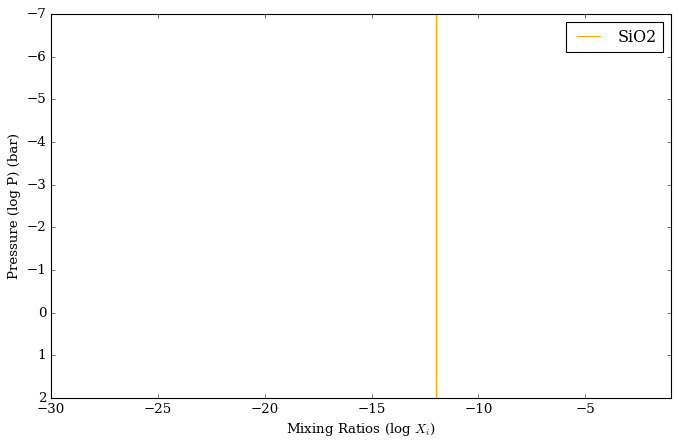

In [47]:
plot_clouds(planet,model_uniform_x,atmosphere_uniform_x)

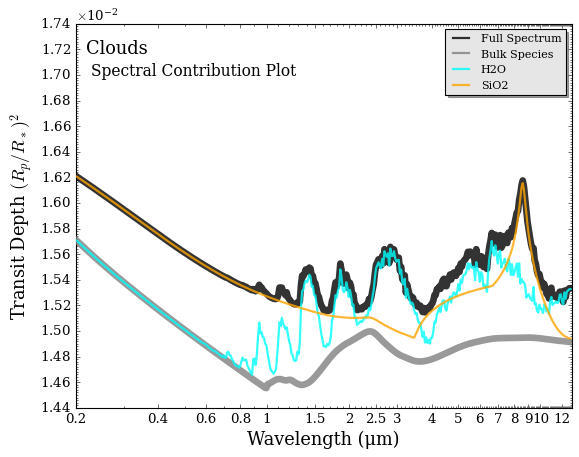

<Figure size 853.36x480 with 0 Axes>

In [48]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x,atmosphere_uniform_x, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

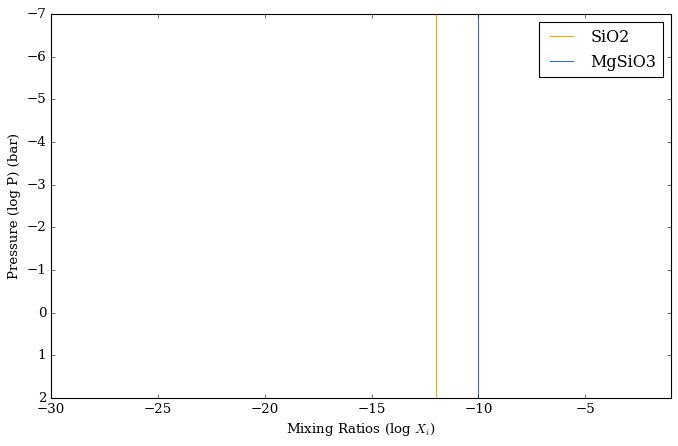

In [49]:
plot_clouds(planet,model_uniform_x_two,atmosphere_uniform_x_two)

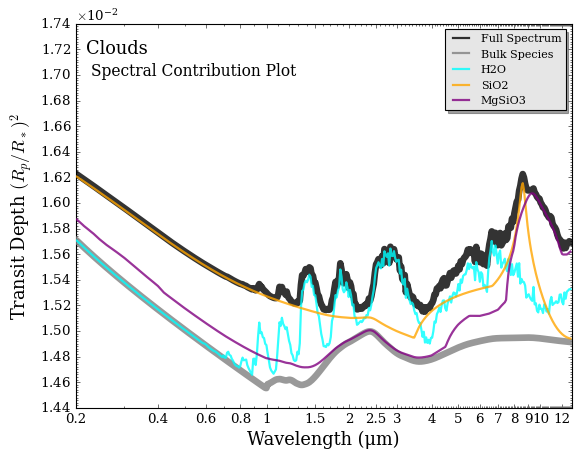

<Figure size 853.36x480 with 0 Axes>

In [50]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x_two,atmosphere_uniform_x_two, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple'])

# Retrieval Information

This module works with retrievals. Follow other tutorials for how to set priors and run the retirevals. 

For retrieval prior reccomendations, please refer to Mullens 2024. 

# Adding your own aerosols

### Using file read and constant refractive indices in a forward model

Note that now the user has the provide the r_i_real and r_i_complex (refractive indices) into cloud params

Note that free and file read only work with the following cloud models : fuzzy deck, slab, uniform x, and opaque cloud plus slab. With free and file read aerosols, you can only have one slab (not multiple slabs)

Remember that using free or file read refractive indices will be slower, since cross sections have to be computed from scratch.

In [51]:
bulk_species = ['H2', 'He']     
param_species = ['H2O']

model_name = 'File_Read'
aerosol_species = ['file_read']

model_file_read = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

model_name = 'Free'
aerosol_species = ['free']
model_free = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

print()
print("Cloud parameters (File Read) : " + str(model_file_read['cloud_param_names']))
print()
print("Cloud parameters (Free) : " + str(model_free['cloud_param_names']))


Cloud parameters (File Read) : ['log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']

Cloud parameters (Free) : ['log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']


In [52]:
from POSEIDON.clouds import load_refractive_indices_from_file

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Cloud Params 
log_r_m        = -2
log_X_Mie          = -12
# Preload the refractive indices from the file 
file_name = './H2O_complex.txt'
r_i_real, r_i_complex = load_refractive_indices_from_file(wl, file_name)

cloud_params = ([log_r_m, log_X_Mie, r_i_real, r_i_complex])
atmosphere_file_read = make_atmosphere(planet, model_file_read, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Loading in :  ./H2O_complex.txt


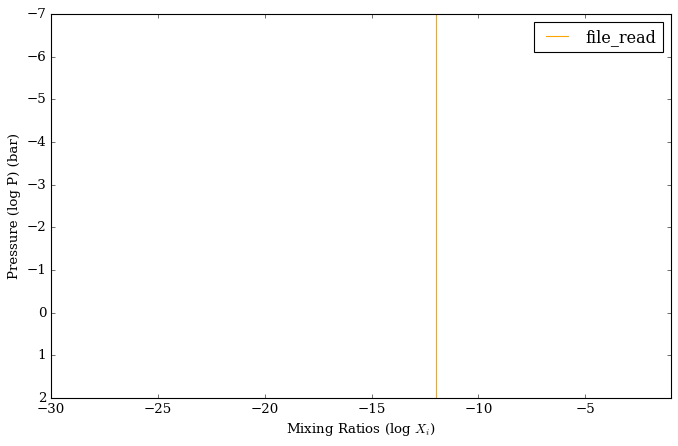

In [53]:
plot_clouds(planet,model_file_read,atmosphere_file_read)

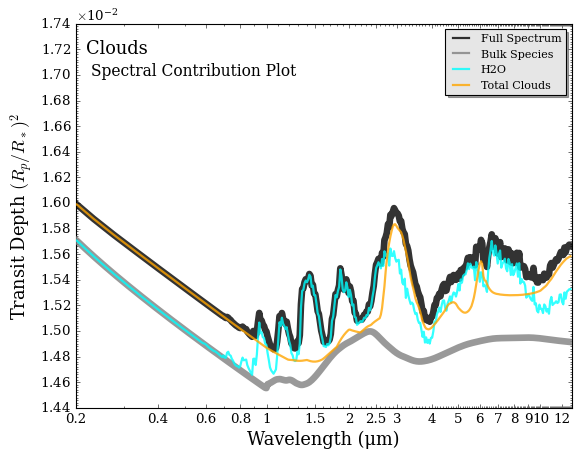

<Figure size 853.36x480 with 0 Axes>

In [54]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_file_read,atmosphere_file_read, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

In [55]:
# Constant refractive indices 
r_i_real, r_i_complex = 1, 1e-3
cloud_params = ([log_r_m, log_X_Mie, r_i_real, r_i_complex])
atmosphere_free = make_atmosphere(planet, model_free, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

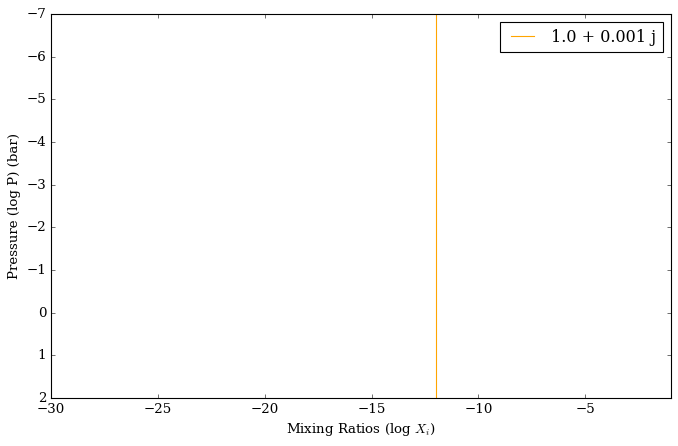

In [56]:
plot_clouds(planet,model_free,atmosphere_free)

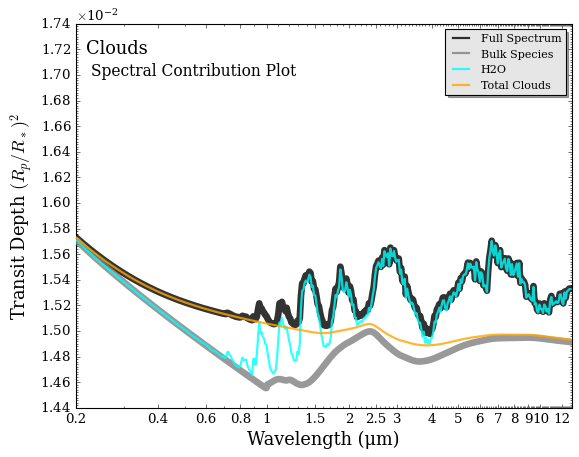

<Figure size 853.36x480 with 0 Axes>

In [57]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_free,atmosphere_free, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

# Cloud Dimension

Mie clouds support a 1 + 1d perscription of patchy clouds. 

This perscription works with all the cloud models above, but for simplicity we will utilize Uniform X.

In [58]:
model_name = 'Uniform_X_patchy'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_uniform_x_patchy = define_model(model_name, bulk_species, param_species,
                        PT_profile = 'isotherm', X_profile = 'isochem',
                        cloud_model = 'Mie',cloud_type = 'uniform_X',
                        aerosol_species = aerosol_species,
                        cloud_dim = 2)

print()
print("Cloud parameters (Uniform X Patchy) : " + str(model_uniform_x_patchy['cloud_param_names']))

Reading in database for aerosol cross sections...

Cloud parameters (Uniform X Patchy) : ['f_cloud' 'log_r_m_SiO2' 'log_X_SiO2']


In [59]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

f_cloud = 0.5
log_r_m_SiO2        = -2
log_X_SiO2          = -12

cloud_params = ([f_cloud, log_r_m_SiO2, log_X_SiO2])
                 
atmosphere_uniform_x_patchy = make_atmosphere(planet, model_uniform_x_patchy, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


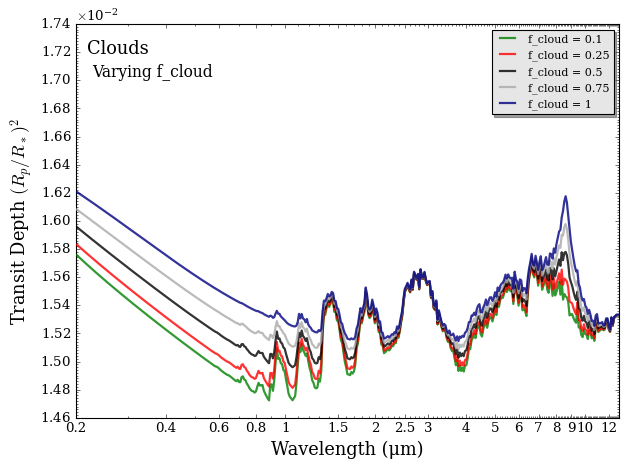

In [60]:
param_name = 'f_cloud'
vary_list = [0.1, 0.25, 0.5, 0.75, 1]

vary_one_parameter(model_uniform_x_patchy, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

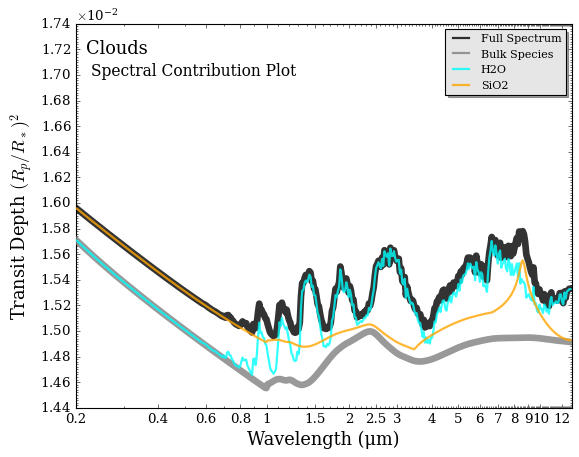

<Figure size 853.36x480 with 0 Axes>

In [63]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x_patchy,atmosphere_uniform_x_patchy, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            put_one_in = True)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'],)